In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GROQ_API_KEY")

In [2]:
from langchain_groq import ChatGroq

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

def subtract(a: int, b: int) -> int:
    """Subtract b from a.

    Args:
        a: first int
        b: second int
    """
    return a - b

def remainder(a: int, b: int) -> int:
    """Find a mod b.

    Args:
        a: first int
        b: second int
    """
    return a % b

tools = [add, multiply, divide, subtract, remainder]
llm = ChatGroq(model="openai/gpt-oss-20b")
llm_with_tools = llm.bind_tools(tools)

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


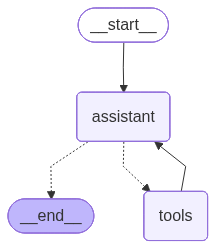

In [3]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=MemorySaver())

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [4]:
# Input
initial_input = {"messages": HumanMessage(content="Add 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Add 2 and 3
================================== Ai Message ==================================
Tool Calls:
  add (fc_3b6276cf-b812-4d62-a766-81facbe480f6)
 Call ID: fc_3b6276cf-b812-4d62-a766-81facbe480f6
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: add

5
================================== Ai Message ==================================

5


In [ ]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Add 2 and 3', additional_kwargs={}, response_metadata={}, id='87450d73-9f6f-4e44-8097-0035748ac0f0'), AIMessage(content='', additional_kwargs={'reasoning_content': 'We need to call add function.', 'tool_calls': [{'id': 'fc_3b6276cf-b812-4d62-a766-81facbe480f6', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 268, 'total_tokens': 302, 'completion_time': 0.034942238, 'prompt_time': 3.917e-05, 'queue_time': 0.04869663, 'total_time': 0.034981408, 'prompt_tokens_details': {'cached_tokens': 256}}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_77f8660d1d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--796b422f-0ab9-4974-8ae2-c8bf1515ba8f-0', tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 3}, 'id': 'fc_3b6276cf-b812-4d62-a766-81facbe480f6',

In [6]:
all_states = [s for s in graph.get_state_history(thread)]

In [7]:
len(all_states)

5

In [8]:
all_states[-2]

StateSnapshot(values={'messages': [HumanMessage(content='Add 2 and 3', additional_kwargs={}, response_metadata={}, id='87450d73-9f6f-4e44-8097-0035748ac0f0')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b25a0-d8f4-65b8-8000-7853181235af'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-10-26T10:53:49.277931+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b25a0-d8f1-6461-bfff-2ef3727bac8e'}}, tasks=(PregelTask(id='fe07be64-120c-75dd-8abc-0c1cfe021e9d', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'reasoning_content': 'We need to call add function.', 'tool_calls': [{'id': 'fc_3b6276cf-b812-4d62-a766-81facbe480f6', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completio

In [9]:
to_replay = all_states[-2]

In [10]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Add 2 and 3', additional_kwargs={}, response_metadata={}, id='87450d73-9f6f-4e44-8097-0035748ac0f0')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b25a0-d8f4-65b8-8000-7853181235af'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-10-26T10:53:49.277931+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b25a0-d8f1-6461-bfff-2ef3727bac8e'}}, tasks=(PregelTask(id='fe07be64-120c-75dd-8abc-0c1cfe021e9d', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'reasoning_content': 'We need to call add function.', 'tool_calls': [{'id': 'fc_3b6276cf-b812-4d62-a766-81facbe480f6', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completio

In [ ]:
to_replay.values

{'messages': [HumanMessage(content='Add 2 and 3', additional_kwargs={}, response_metadata={}, id='87450d73-9f6f-4e44-8097-0035748ac0f0')]}

In [12]:
to_replay.next

('assistant',)

In [13]:
to_replay.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b25a0-d8f4-65b8-8000-7853181235af'}}

In [14]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Add 2 and 3
================================== Ai Message ==================================
Tool Calls:
  add (fc_7fb2506d-c93a-49d3-b2d1-6ac1b0822ea7)
 Call ID: fc_7fb2506d-c93a-49d3-b2d1-6ac1b0822ea7
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: add

5
================================== Ai Message ==================================

5


In [15]:
to_fork = all_states[-2]
to_fork.values["messages"]

[HumanMessage(content='Add 2 and 3', additional_kwargs={}, response_metadata={}, id='87450d73-9f6f-4e44-8097-0035748ac0f0')]

In [16]:
to_fork.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b25a0-d8f4-65b8-8000-7853181235af'}}

In [18]:
fork_config = graph.update_state(
    to_fork.config,
    {"messages": [HumanMessage(content='Find 5 mod 3', 
                               id=to_fork.values["messages"][0].id)]},
)

In [19]:
fork_config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b25a4-5949-6a04-8001-bb69e1fa2d9b'}}

In [20]:
all_states = [state for state in graph.get_state_history(thread) ]
all_states[0].values["messages"]

[HumanMessage(content='Find 5 mod 3', additional_kwargs={}, response_metadata={}, id='87450d73-9f6f-4e44-8097-0035748ac0f0'),
 AIMessage(content='', additional_kwargs={'reasoning_content': 'We need to call add function.', 'tool_calls': [{'id': 'fc_3b6276cf-b812-4d62-a766-81facbe480f6', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 268, 'total_tokens': 302, 'completion_time': 0.034942238, 'prompt_time': 3.917e-05, 'queue_time': 0.04869663, 'total_time': 0.034981408, 'prompt_tokens_details': {'cached_tokens': 256}}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_77f8660d1d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--796b422f-0ab9-4974-8ae2-c8bf1515ba8f-0', tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 3}, 'id': 'fc_3b6276cf-b812-4d62-a766-81facbe480f6', 'type': 'tool_call'}], usage_me

In [21]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Find 5 mod 3', additional_kwargs={}, response_metadata={}, id='87450d73-9f6f-4e44-8097-0035748ac0f0'), AIMessage(content='', additional_kwargs={'reasoning_content': 'We need to call add function.', 'tool_calls': [{'id': 'fc_3b6276cf-b812-4d62-a766-81facbe480f6', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 268, 'total_tokens': 302, 'completion_time': 0.034942238, 'prompt_time': 3.917e-05, 'queue_time': 0.04869663, 'total_time': 0.034981408, 'prompt_tokens_details': {'cached_tokens': 256}}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_77f8660d1d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--796b422f-0ab9-4974-8ae2-c8bf1515ba8f-0', tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 3}, 'id': 'fc_3b6276cf-b812-4d62-a766-81facbe480f6'

In [22]:
for event in graph.stream(None, fork_config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  add (fc_3b6276cf-b812-4d62-a766-81facbe480f6)
 Call ID: fc_3b6276cf-b812-4d62-a766-81facbe480f6
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: add

5
================================== Ai Message ==================================
Tool Calls:
  remainder (fc_d7afb67a-5600-4620-bd27-b7ec1454c2ff)
 Call ID: fc_d7afb67a-5600-4620-bd27-b7ec1454c2ff
  Args:
    a: 5
    b: 3
================================= Tool Message =================================
Name: remainder

2
================================== Ai Message ==================================

2


In [24]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Find 5 mod 3', additional_kwargs={}, response_metadata={}, id='87450d73-9f6f-4e44-8097-0035748ac0f0'), AIMessage(content='', additional_kwargs={'reasoning_content': 'We need to call add function.', 'tool_calls': [{'id': 'fc_3b6276cf-b812-4d62-a766-81facbe480f6', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 268, 'total_tokens': 302, 'completion_time': 0.034942238, 'prompt_time': 3.917e-05, 'queue_time': 0.04869663, 'total_time': 0.034981408, 'prompt_tokens_details': {'cached_tokens': 256}}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_77f8660d1d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--796b422f-0ab9-4974-8ae2-c8bf1515ba8f-0', tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 3}, 'id': 'fc_3b6276cf-b812-4d62-a766-81facbe480f6'